# Pythagoras via Matrix

In [2]:
%matplotlib inline
import math
import random
import operator
import warnings
import numpy as np

from geneticprogramming import Baseset
from geneticprogramming import Individual
from geneticprogramming import Population

warnings.filterwarnings("ignore")

## Training data 

* a number of random matrices (2D floating points) on a plane

In [3]:
SAMPLE_SIZE = 50
PLANE_SIZE = 20.0
RANDOMPOINTS = [PLANE_SIZE * np.random.random_sample((1, 2)) for _ in range(SAMPLE_SIZE)]

## Base functions

* _get_ a value at a location from a matrix
* an _ephemeral integer_ - either 0 or 1
* _addition_ and _subtraction_ of floats
* _square_ and _square root_ of floats

In [7]:
def getValue(ndarray, idx):
    """Return the indexed value from the 1x2 numpy array"""
    return ndarray[0][idx]

square = lambda x: x ** 2
sqrt = lambda x: math.sqrt(abs(x))

bset = Baseset()
# bset.add_ephemeral('E', lambda: random.randint(0, 1), int)
bset.add_primitive(getValue, [np.ndarray, int], float, name="get")
bset.add_primitive(operator.add, [float, float], float, name="add")
bset.add_primitive(operator.sub, [float, float], float, name="sub")
bset.add_primitive(square, [float], float, name="square")
bset.add_primitive(sqrt, [float], float, name="sqrt")

# logic operators
# Define a new if-then-else function
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

bset.add_primitive(operator.lt, [float, float], bool, name="lt")
bset.add_primitive(if_then_else, [bool, float, float], float, name="IF")

bset.add_terminal(True, bool)
bset.add_terminal(False, bool)

## Individuals
* consume a matrix (a 1x2 array of floats - x and y coordinates)
* return a float (the distance from the origin)
* scored by accumulating the error when applying the Training data

In [5]:
Individual.INTYPES = [np.ndarray]
Individual.OUTTYPE = float

def evaluate(individual):
    """sum of application of all the random points"""
    program = individual.compile()
    score = 0
    try:
        for point in RANDOMPOINTS:
            program_distance = program(point)
            true_distance = math.hypot(point[0][0], point[0][1])
            score += abs(true_distance - program_distance)
    except (OverflowError, RuntimeWarning):
        pass
    if math.isnan(score) or score == 0:
        score = 100000

    # accumulate the number of nodes actually used during a run by calling the adfs in the rpb
    nodes = sum([len(tree) for tree in individual.trees])
    modifier = 1 + (-2 ** - (nodes / 250))
    return score + modifier,

Individual.evaluate = evaluate

## Population Evolution

gen	avg        	std        	min    	max        
0  	3.84872e+39	5.42929e+40	108.566	7.69745e+41
1  	139640     	1.79484e+06	108.566	2.53513e+07
2  	22735.7    	222389     	108.56 	2.29487e+06
3  	318.726    	724.715    	108.56 	6221.33    
4  	268.697    	773.729    	108.56 	7895.6     
5  	267.747    	747.232    	80.2994	7275.99    
6  	3043.89    	39545      	80.2798	560827     
7  	297.303    	757.873    	78.9858	7090.22    
8  	241.155    	596.798    	78.9858	5879.37    
9  	287.948    	948.921    	74.5894	7895.65    
10 	189.647    	594.965    	74.5894	8464.36    
11 	189.376    	537.462    	74.5894	7394.38    
12 	180.746    	480.648    	74.5302	6805.07    
13 	143.534    	122.515    	74.5207	758.124    
14 	127.212    	94.4705    	74.5207	663.876    


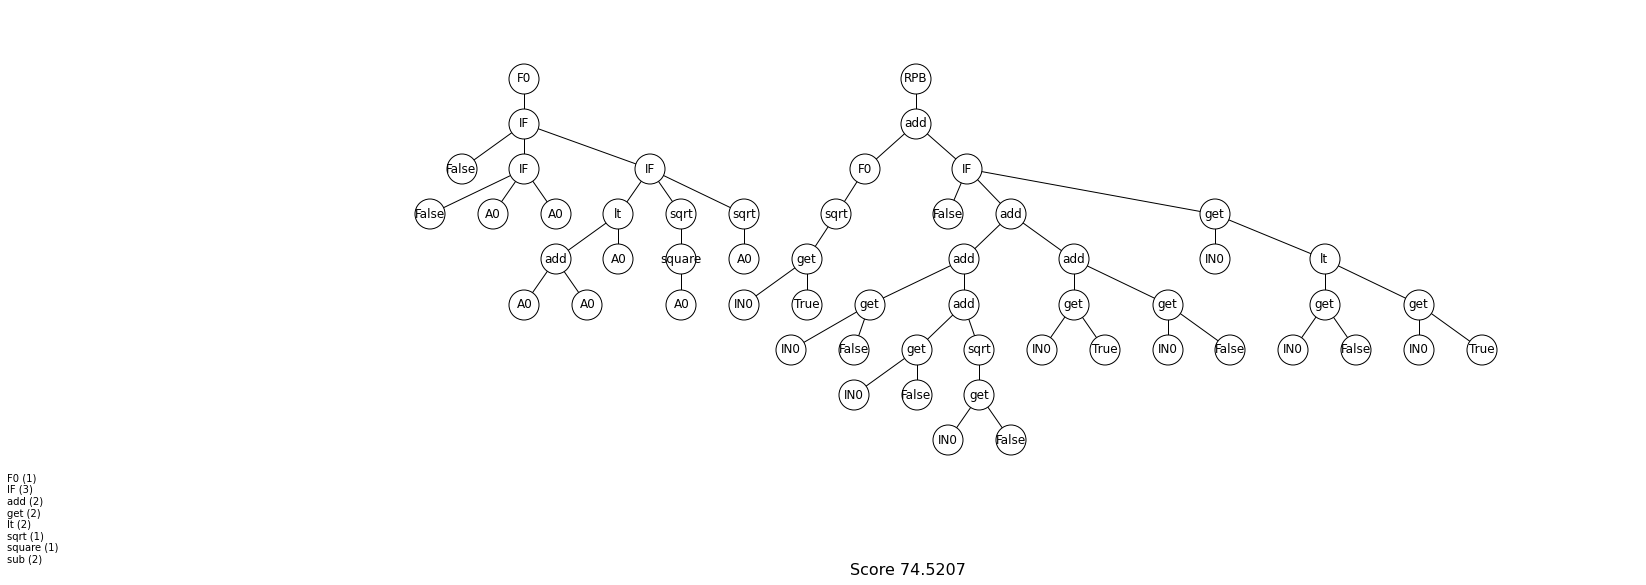

In [8]:
Population.POPULATION_SIZE = 200       # Number of individuals in a generation
Population.MATE_MUTATE_CLONE = (60, 38, 2)   # ratio of individuals to mate, mutate, or clone
Population.CLONE_BEST = 10             # Number of best individuals to seed directly into offspring

Individual.MAX_ADFS = 4                # The maximum number of ADFs to generate
Individual.ADF_NARGS = (1, 5)          # min, max number of input arguments to adfs
Individual.GROWTH_TERM_PB = 0.3        # Probability of terminal when growing:
Individual.GROWTH_MAX_INIT_DEPTH = 5   # Maximum depth of initial growth
Individual.GROWTH_MAX_MUT_DEPTH = 3    # Maximum depth of mutation growth

NUM_GENERATIONS = 15
gen = 0

population = Population(bset)
while population[0].fitness.values[0] >= 1.0 and gen < NUM_GENERATIONS:
    population.evolve()
    gen += 1

best = population[0]
best.draw()